In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func
from scipy.special import gammaln, xlogy
from scipy.integrate import quad
np.random.seed(42)

# Dirichlet Bridge

In [3]:
## functions

def softmax_transform(x):
    
    exp_ = exp(x)
    return(exp_/exp.sum())

def dirichlet_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x = np.array(x)
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))  

    return(np.exp(- coef+ np.sum((xlogy(alpha-1, x.T)).T, 0)))

def dirichlet_t_softmax_pdf(x, alpha):
    
    alpha = np.array(alpha)
    x_sm = softmax_transform(np.array(x))
    coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    
    return(np.exp(- coef+ np.sum((xlogy(alpha, x_sm.T)).T, 0)))

def dirichlet_mu(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    return((alpha-1)/(alpha.sum()- K))
    
def dirichlet_Sigma(alpha):
    alpha = np.array(alpha)
    K = len(alpha)
    diag_ = (alpha - 1)/(alpha.sum() - K)**2
    n = len(alpha)
    S = np.zeros((n,n))
    np.fill_diagonal(S, diag_)
    return(S)
    
# softmax basis

def dirichlet_t_softmax_mu(alpha):
    
    alpha = np.array(alpha)
    log_ = np.log(alpha)
    K = len(alpha)
    return(log_ - 1/K * log_.sum())
    
def dirichlet_t_softmax_Sigma(alpha):
    
    alpha = np.array(alpha)
    K = len(alpha)
    alpha_sum = (1/alpha).sum()
    
    Sigma = np.zeros((K, K))
    for k in range(K):
        for l in range(K):
            v = -1/K * (1/alpha[k] + 1/alpha[l] - 1/K * alpha_sum)
            if k == l:
                v += 1/alpha[k]
            Sigma[k, l] =  v
            
    return(Sigma)

def inverse_softmax_transform(x, c=1):
    # Note: the softmax function is not bijective, hence has not one inverse.
    # inverses have the form of (log(x_0), log(x_1), ...) * C
    return(np.log(x) * c)


In [4]:
def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

In [5]:
## plotting

def plot_dirichlet_t_softmax(params, save=False, filename='dirichlet_softmax_bridge.pdf', show_back=True):
    
    a1 = params[0] 
    a2 = params[1] 
    a3 = params[2] 
    
    x_ = np.linspace(0,1, 1000 +1)
    x = np.array([[x_i, 1-x_i] for x_i in x_])
    
    print("using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)")
    
    mode1 = dirichlet_mu(a1)[0]
    mode2 = dirichlet_mu(a2)[0]
    mode3 = dirichlet_mu(a3)[0]
    
    beta_sigma1 = np.sqrt(beta_var(a1[0], a1[1]))
    beta_sigma2 = np.sqrt(beta_var(a2[0], a2[1]))
    beta_sigma3 = np.sqrt(beta_var(a3[0], a3[1]))
    
    print(beta_sigma2, beta_sigma3)

    y1 = np.array([dirichlet_pdf(_, a1) for _ in x])
    y2 = np.array([dirichlet_pdf(_, a2) for _ in x])
    y3 = np.array([dirichlet_pdf(_, a3) for _ in x])
    
    print(np.shape(y1))
    
    LP_approx1 = norm.pdf(x_, mode1, beta_sigma1)
    LP_approx2 = norm.pdf(x_, mode2, beta_sigma2)
    LP_approx3 = norm.pdf(x_, mode3, beta_sigma3)
    
    print(np.shape(LP_approx1))

    #plot 2: transform to other base
    x_t = np.linspace(-4,4, 1000 + 1)
    
    y1_t_logit = beta_t_logit_pdf(x_t, a1[0], a1[1])
    y2_t_logit = beta_t_logit_pdf(x_t, a2[0], a2[1])
    y3_t_logit = beta_t_logit_pdf(x_t, a3[0], a3[1])

    mode1_t_logit = beta_t_logit_mu(a1[0], a1[1])
    mode2_t_logit = beta_t_logit_mu(a2[0], a2[1])
    mode3_t_logit = beta_t_logit_mu(a3[0], a3[1])

    sigma1_t_logit = np.sqrt(beta_t_logit_var(a1[0], a1[1]))
    sigma2_t_logit = np.sqrt(beta_t_logit_var(a2[0], a2[1]))
    sigma3_t_logit = np.sqrt(beta_t_logit_var(a3[0], a3[1]))

    LP_approx1_t_logit = norm.pdf(x_t, mode1_t_logit, sigma1_t_logit)
    LP_approx2_t_logit = norm.pdf(x_t, mode2_t_logit, sigma2_t_logit)
    LP_approx3_t_logit = norm.pdf(x_t, mode3_t_logit, sigma3_t_logit)
    
    
    #plot 3: transform back and reconstruct
    if show_back:
        y1_back = logit_normal_back(x_, mode1_t_logit, sigma1_t_logit)
        y2_back = logit_normal_back(x_, mode2_t_logit, sigma2_t_logit)
        y3_back = logit_normal_back(x_, mode3_t_logit, sigma3_t_logit)

    """Plots"""
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)
    
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=15
    lw_size=2
    
    if show_back:
        fig, axs = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(23, 6))
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(20, 4))
    #plot beta distribution and LPA in the standard basis
    axs[0].plot(x_, y1, 'r-', lw=lw_size)
    axs[0].plot(x_, y2, 'b-', lw=lw_size)
    axs[0].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[0].plot(x_, LP_approx1, 'r--', lw=lw_size)
    axs[0].plot(x_, LP_approx2, 'b--', lw=lw_size)
    axs[0].plot(x_, LP_approx3, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[0].set_yticklabels([])
    axs[0].set_yticks([])
    axs[0].set_xlabel('$\pi$', fontsize=xlabel_size)
    axs[0].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
    axs[0].set_title('Laplace in standard basis', fontsize=title_size)
    axs[0].legend(prop={'size': legend_size});

    #plot beta distribution in the transformed basis
    axs[1].plot(x_t, y1_t_logit, 'r-', lw=lw_size)
    axs[1].plot(x_t, y2_t_logit, 'b-', lw=lw_size)
    axs[1].plot(x_t, y3_t_logit, 'k-', lw=lw_size, label='$\mathcal{D}$')
    axs[1].plot(x_t, LP_approx1_t_logit, 'r--', lw=lw_size)
    axs[1].plot(x_t, LP_approx2_t_logit, 'b--', lw=lw_size)
    axs[1].plot(x_t, LP_approx3_t_logit, 'k--', lw=lw_size, label='$\mathcal{N}$')
    axs[1].set_xlabel('x', fontsize=xlabel_size)
    axs[1].set_ylabel('$p(x)dx$', fontsize=ylabel_size)
    axs[1].set_yticklabels([])
    axs[1].set_yticks([])
    axs[1].set_title('Laplace in inverse-softmax basis', fontsize=title_size)
    axs[1].legend(prop={'size': legend_size});

    #plot backwards transformation of the LPA from the transformed to the standard basis
    if show_back:
        axs[2].plot(x_, y1, 'r-', lw=lw_size)
        axs[2].plot(x_, y2, 'b-', lw=lw_size)
        axs[2].plot(x_, y3, 'k-', lw=lw_size, label='$\mathcal{D}$')
        axs[2].plot(x_, y1_back, 'r--', lw=lw_size)
        axs[2].plot(x_, y2_back, 'b--', lw=lw_size)
        axs[2].plot(x_, y3_back, 'k--', lw=lw_size, label='$\mathcal{N}$')
        axs[2].set_yticklabels([])
        axs[2].set_yticks([])
        axs[2].set_xlabel('$\pi$', fontsize=xlabel_size)
        axs[2].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
        axs[2].set_title('Transformation back to standard basis', fontsize=title_size)
        axs[2].legend(prop={'size': legend_size});

    plt.tight_layout()
    #plt.show()
    #plt.savefig('BetaVizTransformation.pdf')
    #tpl.save('BetaVizTransformation.tex', figure=fig, tex_relative_path_to_data='.figures', figurewidth='\\figwidth', figureheight='\\figheight',
    #         extra_axis_parameters={'xtick align=inside', 'ytick align=inside', 'xtick pos=left', 'ytick pos=left', 'legend pos=north east'})

    if save:
        plt.savefig(filename)

using only 2D Dirichlet for plotting (i.e. the special case of the Beta dist.)
0.2721655269759087 0.1870439059165649


/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


(1001,)
(1001,)


/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/marius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered

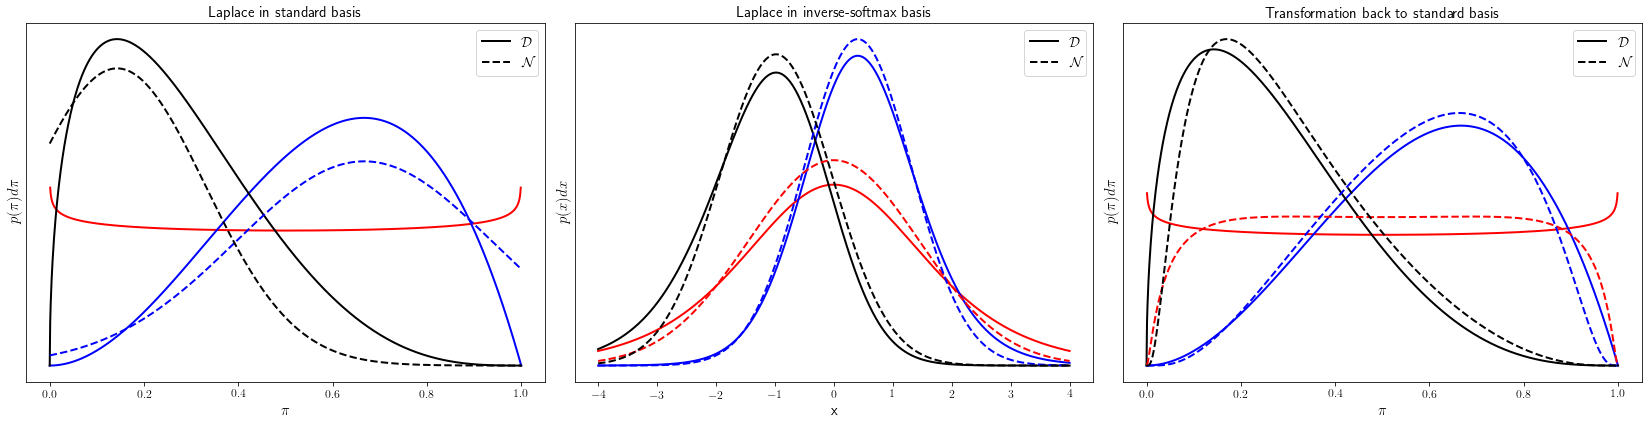

In [6]:
plot_dirichlet_t_softmax(params=[[0.95, 0.95], [3,2], [1.5, 4]], save=True, filename='dirichlet_softmax_bridge.pdf', show_back=True)

# Verify the Bridge

In [7]:
def alpha_from_normal(mu, Sigma):
    
    Sigma_diag = np.diagonal(Sigma)
    sum_mu_exp = np.sum(np.exp(-mu))
    K = len(mu)
    return(1/Sigma_diag * (1 - 2/K + np.exp(mu)/K**2 * sum_mu_exp))

test_a1 = np.array([1,2,3,4])
test_m1, test_S1 = dirichlet_t_softmax_mu(test_a1), dirichlet_t_softmax_Sigma(test_a1)
test_a2 = alpha_from_normal(test_m1, test_S1)
print(test_a2)

test_a3 = np.random.random(4)
test_m3, test_S3 = dirichlet_t_softmax_mu(test_a3), dirichlet_t_softmax_Sigma(test_a3)
test_a4 = alpha_from_normal(test_m3, test_S3)

assert(np.allclose(test_a3, test_a4))

[1. 2. 3. 4.]


# Statistical distance measures

In [8]:
from torch_two_sample import MMDStatistic
from scipy.stats import norm, beta, dirichlet
from scipy.stats import multivariate_normal as mv_norm
import torch

## MMD from 100 combinations of parameters

In [9]:
def MMD_combinations(params, plot=False, n_samples=1000, verbose=True):
    
    As = params
    
    MMD_sum = 0
    MMD_t_softmax_sum = 0 

    for a in As:
            
        if verbose:
            print("a: ", a)
                
        if np.sum(a < 1) != 0:
            print("a_i < 1 doesn't yield a Laplace Approximation in standard basis")

        if np.sum(a) == len(a):
            print("sum of alphas is K, division by zero -> break")
            MMD_ = torch.Tensor([np.nan])
            MMD_softmax_ = torch.Tensor([np.nan])
            
        else:
            #get samples from all dists
            #standard
            D_samples = dirichlet.rvs(a, size=n_samples)
            if np.sum(a < 1) == 0:                
                mode1 = dirichlet_mu(a)
                Sigma1 = dirichlet_Sigma(a)
                N_samples = mv_norm.rvs(mode1, Sigma1, size=n_samples)

            #softmax
            mode1_softmax = dirichlet_t_softmax_mu(a)
            Sigma1_softmax = dirichlet_t_softmax_Sigma(a)
            D_samples_softmax = inverse_softmax_transform(D_samples)
            #we align the means of the normal and the inverse softmax transform since we don't know the
            #exact value of the constant for the inversion c
            N_samples_softmax = mv_norm.rvs(mode1_softmax, Sigma1_softmax, size=n_samples)
            N_samples_softmax += np.mean(D_samples_softmax, axis=1).reshape(-1, 1)
            #print(np.shape(np.mean(D_samples_softmax, axis=1)))


            #calculate MMD for all bases
            MMD = MMDStatistic(n_samples, n_samples)

            #standard
            D_samples_ = torch.Tensor(D_samples.reshape((n_samples, -1)))
            if np.sum(a < 1) == 0:
                N_samples_ = torch.Tensor(N_samples.reshape((n_samples, -1)))
                MMD_ = MMD(D_samples_, N_samples_,  alphas=[0.5], ret_matrix=False)
                MMD_ = torch.max(torch.zeros(1), MMD_)
            else:
                MMD_ = torch.Tensor([np.nan])

            #softmax
            D_samples_softmax_ = torch.Tensor(D_samples_softmax.reshape((n_samples, -1)))
            N_samples_softmax_ = torch.Tensor(N_samples_softmax.reshape((n_samples, -1)))
            MMD_softmax_= MMD(D_samples_softmax_, N_samples_softmax_,  alphas=[0.5], ret_matrix=False)

            #why?
            MMD_softmax_= torch.max(torch.zeros(1), MMD_softmax_)


            if plot:
                print("plot the marginal of the first entry for the Dirichlet (which is a beta distribution)")
                n_bins = int(np.sqrt(n_samples))
                fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(23, 6))
                axs[0].hist(D_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[0].hist(N_samples[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[0].set_title('standard basis')
                axs[0].legend()

                axs[1].hist(D_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{B}$')
                axs[1].hist(N_samples_softmax[:,0], bins = n_bins, alpha=0.5, label='$\mathcal{N}$')
                axs[1].set_title('inverse softmax basis')
                axs[1].legend()

                plt.show()

            if verbose: 
                print("standard: ", MMD_.item(), "softmax: ", MMD_softmax_.item())

        #add them to their respective sums
        MMD_sum += MMD_
        MMD_t_softmax_sum += MMD_softmax_
        
    return(MMD_sum, MMD_t_softmax_sum)
    #return(MMD_sum.item(), MMD_t_softmax_sum.item())

In [10]:
np.random.seed(42)
random_params = np.random.uniform(low=1.0, high=3.0, size=(100, 4))
MMD_combinations(params=random_params, plot=False, verbose=True, n_samples=2000)

a:  [1.74908024 2.90142861 2.46398788 2.19731697]
standard:  0.009322106838226318 softmax:  0.0068031251430511475
a:  [1.31203728 1.31198904 1.11616722 2.73235229]
standard:  0.08663374185562134 softmax:  0.018397927284240723
a:  [2.20223002 2.41614516 1.04116899 2.9398197 ]
standard:  0.023017585277557373 softmax:  0.015662938356399536
a:  [2.66488528 1.42467822 1.36364993 1.36680902]
standard:  0.05393171310424805 softmax:  0.013710469007492065
a:  [1.60848449 2.04951286 1.86389004 1.58245828]
standard:  0.016904175281524658 softmax:  0.009126871824264526
a:  [2.22370579 1.27898772 1.5842893  1.73272369]
standard:  0.03467839956283569 softmax:  0.009949415922164917
a:  [1.91213997 2.57035192 1.39934756 2.02846888]
standard:  0.017300128936767578 softmax:  0.011103957891464233
a:  [2.18482914 1.09290083 2.2150897  1.34104825]
standard:  0.05053192377090454 softmax:  0.014344662427902222
a:  [1.13010319 2.89777107 2.93126407 2.6167947 ]
standard:  0.014562606811523438 softmax:  0.01722

standard:  0.02556520700454712 softmax:  0.011594384908676147
a:  [2.53998711 1.43164205 2.24578095 1.17069493]
standard:  0.04219841957092285 softmax:  0.013599157333374023
a:  [1.10336344 2.06270926 2.08127024 2.2748598 ]
standard:  0.026914358139038086 softmax:  0.012261271476745605
a:  [2.45218267 2.95170416 2.0326007  1.64591295]
standard:  0.010020256042480469 softmax:  0.009613841772079468
a:  [2.59037239 1.5416645  1.87794284 1.15691276]
standard:  0.038450539112091064 softmax:  0.013211444020271301
a:  [1.05070149 2.92529683 2.67196024 2.39194841]
standard:  0.018179893493652344 softmax:  0.01886764168739319
a:  [1.81790589 1.34658864 1.31287409 1.5004858 ]
standard:  0.04625582695007324 softmax:  0.01383914053440094
a:  [2.09845333 2.42919185 2.32039475 1.55986779]
standard:  0.01126408576965332 softmax:  0.009081244468688965
a:  [2.90973056 2.47579383 2.10870811 2.22344149]
standard:  0.004775285720825195 softmax:  0.00604015588760376
a:  [1.83920012 1.49546198 1.71194536 2.

(tensor([3.4221]), tensor([1.2087]))

In [11]:
results_MMD = np.array([3.423650026321411, 1.2087279558181763])
results_MMD_normed = results_MMD/results_MMD[0]
print(results_MMD_normed)

[1.         0.35305243]


## KL-divergence (mode seeking/backward, from samples)

In [12]:
from scipy.stats import dirichlet
from scipy.stats import multivariate_normal as mv_norm

a_test = np.array([3,2,1])

In [13]:
def KL_div_samples_dirichlet(a, num_samples, softmax=False, plot=False):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples))
    
    if softmax:
    
        dir_samples_inv_sm = inverse_softmax_transform(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a)
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a)
        norm_samples = mv_norm.rvs(mu_dir_inv_sm, Sigma_dir_inv_sm, size=num_samples)

        q_min = np.array([norm_samples[:, i].min() for i in range(len(a))])
        q_max = np.array([norm_samples[:, i].max() for i in range(len(a))])
        p_min = np.array([dir_samples_inv_sm[:, i].min() for i in range(len(a))])
        p_max = np.array([dir_samples_inv_sm[:, i].max() for i in range(len(a))])
        
        rangedd = [[np.min([q_min[i], p_min[i]]), np.max([q_max[i], p_max[i]])] for i in range(len(a))]

        p_hist, _ = np.histogramdd(dir_samples_inv_sm, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)
        q_hist, _ = np.histogramdd(norm_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)

        KL_div = np.sum(p_hist * np.log(p_hist/(q_hist + 1e-8) + 1e-8))
        
        if plot:
            print("plotting a 1D marginal of the Dirichlet which is a Beta")
            plt.plot(p_hist[4,:,4], label='phist')
            plt.plot(q_hist[4,:,4], label='qhist')
            plt.legend()
            plt.show()

        return(KL_div)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        norm_samples = mv_norm.rvs(mu_dir, Sigma_dir, size=num_samples)

        q_min = np.array([norm_samples[:, i].min() for i in range(len(a))])
        q_max = np.array([norm_samples[:, i].max() for i in range(len(a))])
        p_min = np.array([dirichlet_samples[:, i].min() for i in range(len(a))])
        p_max = np.array([dirichlet_samples[:, i].max() for i in range(len(a))])
        
        rangedd = [[np.min([q_min[i], p_min[i]]), np.max([q_max[i], p_max[i]])] for i in range(len(a))]

        p_hist, _ = np.histogramdd(dirichlet_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)
        q_hist, _ = np.histogramdd(norm_samples, density=True, bins=[num_bins,num_bins,num_bins], range=rangedd)

        KL_div = np.sum(p_hist * np.log(p_hist/(q_hist + 1e-8) + 1e-8))
        
        if plot:
            print("plotting a 1D marginal of the Dirichlet which is a Beta")
            plt.plot(p_hist[4,:,4], label='phist')
            plt.plot(q_hist[4,:,4], label='qhist')
            plt.legend()
            plt.show()

        return(KL_div)



plotting a 1D marginal of the Dirichlet which is a Beta


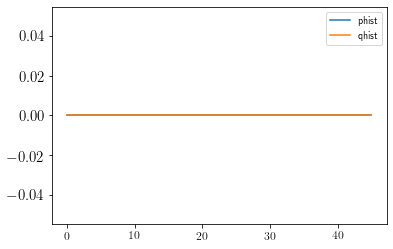

172087.18089544674
plotting a 1D marginal of the Dirichlet which is a Beta


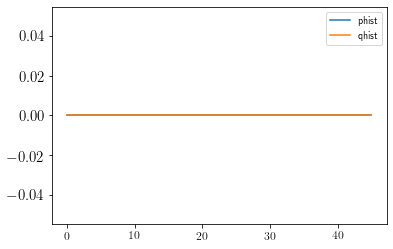

1418.2725239745603


In [14]:
print(KL_div_samples_dirichlet(a_test, 100000, plot=True))
print(KL_div_samples_dirichlet(a_test, 100000, softmax=True, plot=True))

In [15]:
def KL_div_samples_combinations(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet(a, num_samples=num_samples, plot=False)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet(a, num_samples=num_samples, softmax=True, plot=False)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

In [16]:
a_s = np.array([1.1, 1.1, 1.1])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
KL_div_samples_combinations(test_As, num_samples=100000, verbose=True)

a:  [1.1 1.1 1.1]
standard:  590.0148309063842 inverse softmax:  430.68622003264903
a:  [2 2 3]
standard:  15382.692790409137 inverse softmax:  2279.2096251279813
a:  [ 8  9 10]
standard:  242646.15182655712 inverse softmax:  27364.920693499458


(258618.85944787264, 30074.81653866009)

# KL-divergence from samples attempt 2

In [17]:
def KL_div_samples_dirichlet2(a, num_samples, softmax=False, plot=False):
    
    dirichlet_samples = dirichlet.rvs(a, size=num_samples)
    num_bins = int(np.cbrt(num_samples))
    
    if softmax:
    
        dir_samples_inv_sm = inverse_softmax_transform(dirichlet_samples)
        mu_dir_inv_sm = dirichlet_t_softmax_mu(a)
        Sigma_dir_inv_sm = dirichlet_t_softmax_Sigma(a)
        
        s = np.array(dir_samples_inv_sm)
        p_ = dirichlet_t_softmax_pdf(s, a)
        q_ = norm.pdf(s, mu_dir_inv_sm, Sigma_dir_inv_sm)
        KL_div_inv_sm_ = np.mean(np.log(p_/q_))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            plt.plot(x_, dirichlet_t_softmax_pdf(x_, a, b)[:,0])
            plt.plot(x_, norm.pdf(x_, mu_dir_inv_sm, Sigma_dir_inv_sm)[:,0])
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
    
    else:
    
        mu_dir = dirichlet_mu(a)
        Sigma_dir = dirichlet_Sigma(a)
        
        s = np.array(dirichlet_samples)
        p_ = dirichlet_pdf(s, a)
        q_ = norm.pdf(s, mu_dir, Sigma_dir)
        KL_div_inv_sm_ = np.mean(np.log(p_/q_))
            
        if plot:
            x_ = np.linspace(s[:,0].min(), s[:,0].max(), 1000+1)
            plt.hist(s[:,0], density=True, bins=num_bins)
            plt.plot(x_, dirichlet_pdf(x_, a, b)[:,0])
            plt.plot(x_, norm.pdf(x_, mu_dir, Sigma_dir)[:,0])
            plt.title('softmax-base marginal')
            plt.show();
        
        return(KL_div_inv_sm_)
        
        


In [18]:
def KL_div_samples_combinations2(params, num_samples, plot=False, verbose=True):
    
    As = params
    
    KL_div_sum = 0
    KL_div_sm_sum = 0

    for a in As:

        if verbose:
            print("a: ", a)

        if np.min(a) < 1: #if it contains a value smaller than 1
            print("a_i < 1: not legitimate in standard base")
            KL_div_ = np.nan
        else:
            KL_div_ = KL_div_samples_dirichlet2(a, num_samples=num_samples, plot=False)

        #compute KL-div for logit base
        KL_div_sm_ = KL_div_samples_dirichlet2(a, num_samples=num_samples, softmax=True, plot=False)
        KL_div_sm_sum += KL_div_sm_
        KL_div_sum += KL_div_

        if verbose:
            print("standard: ", KL_div_, "inverse softmax: ", KL_div_sm_)

            
    return(KL_div_sum, KL_div_sm_sum)

In [19]:
a_s = np.array([1.1, 1.1, 1.1])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

test_As = [a_s, a_m, a_l]
KL_div_samples_combinations(test_As, num_samples=10000, verbose=True)

a:  [1.1 1.1 1.1]
standard:  56.11213150612213 inverse softmax:  64.157621156101
a:  [2 2 3]
standard:  2027.3540878373933 inverse softmax:  423.19631467992934
a:  [ 8  9 10]
standard:  25345.40501688041 inverse softmax:  3531.799332087348


(27428.871236223924, 4019.1532679233783)

# Statistical distance measures for small, medium and large $\theta$

In [26]:
a_s = np.array([1.1, 1.1, 1.1])
a_m = np.array([2,2,3])
a_l = np.array([8,9,10])

## calculate MMD for the three pairs of parameters

In [27]:
# use 10 seeds
MMD_results_s = []
MMD_results_m = []
MMD_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)
    MMD_s = MMD_combinations(params = [a_s], n_samples=2000)
    MMD_m = MMD_combinations(params = [a_m], n_samples=2000)
    MMD_l = MMD_combinations(params = [a_l], n_samples=2000)
    MMD_results_s += [MMD_s]
    MMD_results_m += [MMD_m]
    MMD_results_l += [MMD_l]
    
MMD_results_mean_s = np.array(MMD_results_s).mean(0)
MMD_results_mean_m = np.array(MMD_results_m).mean(0)
MMD_results_mean_l = np.array(MMD_results_l).mean(0)
print(MMD_results_mean_s)
print(MMD_results_mean_m)
print(MMD_results_mean_l)

seed:  0
a:  [1.1 1.1 1.1]
standard:  0.41055238246917725 softmax:  0.017788678407669067
a:  [2 2 3]
standard:  0.014296412467956543 softmax:  0.007753819227218628
a:  [ 8  9 10]
standard:  0.00016361474990844727 softmax:  0.0002256631851196289
seed:  1
a:  [1.1 1.1 1.1]
standard:  0.41200727224349976 softmax:  0.017946213483810425
a:  [2 2 3]
standard:  0.014420688152313232 softmax:  0.006688296794891357
a:  [ 8  9 10]
standard:  0.00038492679595947266 softmax:  0.00020843744277954102
seed:  2
a:  [1.1 1.1 1.1]
standard:  0.41212284564971924 softmax:  0.01704511046409607
a:  [2 2 3]
standard:  0.013623297214508057 softmax:  0.00837022066116333
a:  [ 8  9 10]
standard:  0.00024044513702392578 softmax:  4.291534423828125e-06
seed:  3
a:  [1.1 1.1 1.1]
standard:  0.4089811444282532 softmax:  0.018064767122268677
a:  [2 2 3]
standard:  0.014765381813049316 softmax:  0.005808383226394653
a:  [ 8  9 10]
standard:  0.00024694204330444336 softmax:  0.00015693902969360352
seed:  4
a:  [1.1 1.1

In [28]:
# normalize to 1 for comparison
#MMD_results_mean_s[0] = MMD_results_mean_s[1:].max()
MMD_results_mean_s_normalized = MMD_results_mean_s/MMD_results_mean_s.max()
#MMD_results_mean_s_normalized[0] = np.nan
print(MMD_results_mean_s_normalized)
print(MMD_results_mean_m/MMD_results_mean_m.max())
print(MMD_results_mean_l/MMD_results_mean_l.max())

[1.         0.04341122]
[1.        0.5218913]
[1.         0.88072836]


## calculate KL div for the three parameters

In [29]:
def KL_combinations(params, n_samples=10000, verbose=True):
    
    a = np.array(params).reshape(-1)

    mu = dirichlet_mu(a)
    Sigma = dirichlet_Sigma(a)

    D_samples = dirichlet.rvs(a, size=n_samples)
    N_samples = mv_norm.rvs(mu, Sigma, size=n_samples)
    
    KL_ = KL_divergence_samples(D_samples, N_samples, plot=False)
    
    ####softmax base
    mode1_softmax = dirichlet_t_softmax_mu(a)
    Sigma1_softmax = dirichlet_t_softmax_Sigma(a)
    D_samples_softmax = inverse_softmax_transform(D_samples)
    N_samples_softmax = mv_norm.rvs(mode1_softmax, Sigma1_softmax, size=n_samples)
    
    KL_softmax_ = KL_divergence_samples(D_samples_softmax, N_samples_softmax, plot=False)
    
    if verbose: 
            print("standard: ", KL_.item(), "softmax: ", KL_softmax_.item())
            
    return([KL_, KL_softmax_])

In [30]:
# use 10 seeds
KL_results_s = []
KL_results_m = []
KL_results_l = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    torch.manual_seed(s)    
    KL_s = KL_combinations(params = [a_s], n_samples=100000)
    KL_m = KL_combinations(params = [a_m], n_samples=100000)
    KL_l = KL_combinations(params = [a_l], n_samples=100000)
    KL_results_s += [KL_s]
    KL_results_m += [KL_m]
    KL_results_l += [KL_l]
    
KL_results_mean_s = np.array(KL_results_s).mean(0)
KL_results_mean_m = np.array(KL_results_m).mean(0)
KL_results_mean_l = np.array(KL_results_l).mean(0)
print(KL_results_mean_s)
print(KL_results_mean_m)
print(KL_results_mean_l)

seed:  0


NameError: name 'KL_divergence_samples' is not defined

In [ ]:
# normalize to 1 for comparison
#KL_results_mean_s[0] = KL_results_mean_s[1:].max()
KL_results_mean_s_normalized = KL_results_mean_s/KL_results_mean_s.max()
#KL_results_mean_s_normalized[0] = np.nan
print(KL_results_mean_s_normalized)
print(KL_results_mean_m/KL_results_mean_m.max())
print(KL_results_mean_l/KL_results_mean_l.max())

# Calculate KL-divergence for growing a_i and plot it

In [32]:
a_0 = np.array([0.6, 0.6, 0.6])
multiplier = np.array([1.5, 1, 0.5])
As = np.array([np.array(a_0 * multiplier * i) for i in range(1,11)])
print(As)

[[0.9 0.6 0.3]
 [1.8 1.2 0.6]
 [2.7 1.8 0.9]
 [3.6 2.4 1.2]
 [4.5 3.  1.5]
 [5.4 3.6 1.8]
 [6.3 4.2 2.1]
 [7.2 4.8 2.4]
 [8.1 5.4 2.7]
 [9.  6.  3. ]]


In [33]:
KL_results_linear = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        KL_ = KL_div_samples_combinations([a_], verbose=True, num_samples=100000)
        print(KL_)
        results_seed.append(KL_)
    
    KL_results_linear.append(results_seed)

seed:  0
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  56.9686819627085
(nan, 56.9686819627085)
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  481.40800344999565
(nan, 481.40800344999565)
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  1051.9656136217145
(nan, 1051.9656136217145)
[3.6 2.4 1.2]
a:  [3.6 2.4 1.2]
standard:  44066.22704592699 inverse softmax:  2414.1876615618953
(44066.22704592699, 2414.1876615618953)
[4.5 3.  1.5]
a:  [4.5 3.  1.5]
standard:  41396.25646941316 inverse softmax:  3171.9057110752233
(41396.25646941316, 3171.9057110752233)
[5.4 3.6 1.8]
a:  [5.4 3.6 1.8]
standard:  67080.53591251378 inverse softmax:  4459.517907020417
(67080.53591251378, 4459.517907020417)
[6.3 4.2 2.1]
a:  [6.3 4.2 2.1]
standard:  78608.04837889627 inverse softmax:  6565.477133611921
(78608.04837889627, 6565.47713361

standard:  147734.44390586822 inverse softmax:  10050.172352613128
(147734.44390586822, 10050.172352613128)
seed:  6
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  70.02706236363517
(nan, 70.02706236363517)
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  418.70125462590045
(nan, 418.70125462590045)
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1: not legitimate in standard base
standard:  nan inverse softmax:  1208.18655688799
(nan, 1208.18655688799)
[3.6 2.4 1.2]
a:  [3.6 2.4 1.2]
standard:  46696.031625184056 inverse softmax:  1875.609496801779
(46696.031625184056, 1875.609496801779)
[4.5 3.  1.5]
a:  [4.5 3.  1.5]
standard:  49614.67670877946 inverse softmax:  2866.8887209298337
(49614.67670877946, 2866.8887209298337)
[5.4 3.6 1.8]
a:  [5.4 3.6 1.8]
standard:  68709.55974066013 inverse softmax:  3726.9544604895973
(68709.55974066013, 3726.9544604895973)
[6.3 4.2 2.1]
a:  [6.3

In [34]:
# handle the data
KL_results_linear = np.array(KL_results_linear)

# take the mean over the 10 seeds
KL_results_linear_mean = KL_results_linear.mean(0)
print(np.shape(KL_results_linear_mean))

(10, 2)


In [35]:
KL_results_linear_mean

array([[           nan, 6.47419549e+01],
       [           nan, 4.18736676e+02],
       [           nan, 1.03174002e+03],
       [4.35578114e+04, 2.09897236e+03],
       [4.79360129e+04, 3.01062588e+03],
       [6.61925897e+04, 4.46710642e+03],
       [7.93474020e+04, 6.00206474e+03],
       [1.02555879e+05, 7.33379863e+03],
       [1.21526811e+05, 9.30157916e+03],
       [1.49678755e+05, 1.15898294e+04]])

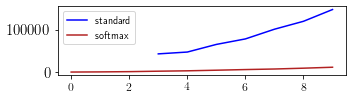

In [36]:
# make plots

plt.figure(figsize=(5, 1.5))
plt.plot(KL_results_linear_mean[:,0], label='standard', color='blue')
plt.plot(KL_results_linear_mean[:,1], label='softmax', color='firebrick')
plt.legend()
plt.tight_layout()
plt.savefig('KL_Dirichlet.pdf')

plt.show();

# calculate MMD for growing a_i and plot it

In [37]:
MMD_results_linear = []

for s in range(10):
    print("seed: ", s)
    np.random.seed(s)
    
    results_seed = []
    for a_ in As:
        print(a_)
        MMD_ = MMD_combinations(params = [a_], n_samples=2000)
        print(MMD_)
        results_seed.append(MMD_)
    
    MMD_results_linear.append(results_seed)

seed:  0
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.03175912797451019
(tensor([nan]), tensor([0.0318]))
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.03200444579124451
(tensor([nan]), tensor([0.0320]))
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.026094704866409302
(tensor([nan]), tensor([0.0261]))
[3.6 2.4 1.2]
a:  [3.6 2.4 1.2]
standard:  0.027932822704315186 softmax:  0.019458383321762085
(tensor([0.0279]), tensor([0.0195]))
[4.5 3.  1.5]
a:  [4.5 3.  1.5]
standard:  0.01583230495452881 softmax:  0.01446765661239624
(tensor([0.0158]), tensor([0.0145]))
[5.4 3.6 1.8]
a:  [5.4 3.6 1.8]
standard:  0.008881211280822754 softmax:  0.010918080806732178
(tensor([0.0089]), tensor([0.0109]))
[6.3 4.2 2.1]
a:  [6.3 4.2 2.1]
standard:  0.007078886032104492 softmax

standard:  0.006480753421783447 softmax:  0.010150372982025146
(tensor([0.0065]), tensor([0.0102]))
[7.2 4.8 2.4]
a:  [7.2 4.8 2.4]
standard:  0.004500329494476318 softmax:  0.009196102619171143
(tensor([0.0045]), tensor([0.0092]))
[8.1 5.4 2.7]
a:  [8.1 5.4 2.7]
standard:  0.0033910274505615234 softmax:  0.006644546985626221
(tensor([0.0034]), tensor([0.0066]))
[9. 6. 3.]
a:  [9. 6. 3.]
standard:  0.0026923418045043945 softmax:  0.00807809829711914
(tensor([0.0027]), tensor([0.0081]))
seed:  6
[0.9 0.6 0.3]
a:  [0.9 0.6 0.3]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.03198423981666565
(tensor([nan]), tensor([0.0320]))
[1.8 1.2 0.6]
a:  [1.8 1.2 0.6]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.03077787160873413
(tensor([nan]), tensor([0.0308]))
[2.7 1.8 0.9]
a:  [2.7 1.8 0.9]
a_i < 1 doesn't yield a Laplace Approximation in standard basis
standard:  nan softmax:  0.02701789140701294
(tensor([

In [38]:
# handle the data
MMD_results_linear = np.array(MMD_results_linear)

# take the mean over the 10 seeds
MMD_results_linear_mean = MMD_results_linear.mean(0)
print(np.shape(MMD_results_linear_mean))

(10, 2)


In [39]:
MMD_results_linear_mean

array([[       nan, 0.03115432],
       [       nan, 0.03079825],
       [       nan, 0.02468648],
       [0.0301125 , 0.01944377],
       [0.01596848, 0.01570692],
       [0.0095034 , 0.01289322],
       [0.00686924, 0.01048868],
       [0.00452125, 0.00911365],
       [0.00336032, 0.00794969],
       [0.00274405, 0.00688993]], dtype=float32)

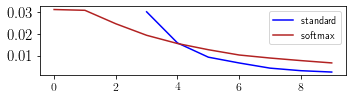

In [40]:
# make plots

plt.figure(figsize=(5, 1.5))
plt.plot(MMD_results_linear_mean[:,0], label='standard', color='blue')
plt.plot(MMD_results_linear_mean[:,1], label='softmax', color='firebrick')
plt.legend()
plt.tight_layout()
plt.savefig('MMD_Dirichlet.pdf')

plt.show();